In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('../../Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
print(df)

In [ ]:
for col in ['HARE', 'LYNX']:
    df[f'{col}_lag1'] = df[col].shift(1)

df['Lynx_on_Hare'] = df['LYNX_lag1'] * df['HARE']
df.dropna(inplace=True)
print(df)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['HARE', 'LYNX', 'HARE_lag1', 'LYNX_lag1', 'Lynx_on_Hare']])
print(scaled_data)

In [ ]:
xs, ys = [], []
seq_length=3
for i in range(len(scaled_data)-seq_length):
    x = scaled_data[i:(i + seq_length)]
    xs.append(x)

    y = scaled_data[i + seq_length][:2]
    ys.append(y)

X, y = np.array(xs), np.array(ys)
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 5)),
    Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32, verbose=0)
    
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    
    print(f'Epoch {epoch+1}/{epochs}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
print(f'Final Test MSE: {final_mse_test}')

In [3]:
df = pd.read_csv('../../Datasets/study_373/top_5_373.csv', usecols=['DATE', '46670', '46982', '46504', '46571', '46888'])
print(df)

           DATE  46670  46982  46504  46571  46888
0    2008-06-08    1.0    2.0    1.0    1.0    2.0
1    2008-07-11    1.0    3.0    1.0    1.0    2.0
2    2008-09-14    2.0    6.0    2.0    1.0    1.0
3    2008-09-16    2.0    1.0    1.0    1.0    3.0
4    2008-09-22    2.0    4.0    1.0    1.0    2.0
..          ...    ...    ...    ...    ...    ...
388  2012-10-18   10.0    6.0    1.0    1.0    2.0
389  2012-10-22    8.0    6.0    1.0    1.0    3.0
390  2012-10-28    3.0    1.0    1.0    1.0    2.0
391  2012-11-08    2.0    7.0    1.0    1.0    2.0
392  2012-11-09    2.0    1.0    1.0    1.0    1.0

[393 rows x 6 columns]


In [4]:
for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)

# 46670  Nyctereutes procyonoides	common raccoon dog  -> Rodents, Japanese Hare
# 46982  Sus scrofa				    wild boar           -> Rodents, Japanese Hare
# 46504  Lepus brachyurus			Japanese Hare
# 46571  Meles anakuma			    Japanese Badger     -> Rodents
# 46888  Rodentia	

# 46670 Nyctereutes procyonoides	common raccoon dog  -> Rodents, Japanese Hare
df['46670_on_46888'] = df['46670_lag1'] * df['46888']
df['46670_on_46504'] = df['46670_lag1'] * df['46504']

# 46982 Sus scrofa				    wild boar           -> Rodents, Japanese Hare
df['46982_on_46888'] = df['46982_lag1'] * df['46888']
df['46982_on_46504'] = df['46982_lag1'] * df['46504']

# 46571 Meles anakuma			    Japanese Badger     -> Rodents
df['46571_on_46888'] = df['46571_lag1'] * df['46888']

df.dropna(inplace=True)
print(df)

           DATE  46670  46982  46504  46571  46888  46670_lag1  46982_lag1  \
1    2008-07-11    1.0    3.0    1.0    1.0    2.0         1.0         2.0   
2    2008-09-14    2.0    6.0    2.0    1.0    1.0         1.0         3.0   
3    2008-09-16    2.0    1.0    1.0    1.0    3.0         2.0         6.0   
4    2008-09-22    2.0    4.0    1.0    1.0    2.0         2.0         1.0   
5    2008-09-25    2.0    4.0    1.0    1.0    3.0         2.0         4.0   
..          ...    ...    ...    ...    ...    ...         ...         ...   
388  2012-10-18   10.0    6.0    1.0    1.0    2.0        12.0         9.0   
389  2012-10-22    8.0    6.0    1.0    1.0    3.0        10.0         6.0   
390  2012-10-28    3.0    1.0    1.0    1.0    2.0         8.0         6.0   
391  2012-11-08    2.0    7.0    1.0    1.0    2.0         3.0         1.0   
392  2012-11-09    2.0    1.0    1.0    1.0    1.0         2.0         7.0   

     46504_lag1  46571_lag1  46888_lag1  46670_on_46888  46670_

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['46670', '46982',  '46504',  '46571',  '46888',
                                       '46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1',
                                       '46670_on_46888', '46670_on_46504', '46982_on_46888', '46982_on_46504', '46571_on_46888']])
print(scaled_data.shape)

(392, 15)


In [16]:
xs, ys = [], []
seq_length=3
for i in range(len(scaled_data)-seq_length):
    x = scaled_data[i:(i + seq_length)]
    xs.append(x)

    y = scaled_data[i + seq_length][:5]
    ys.append(y)

X, y = np.array(xs), np.array(ys)
print(X.shape)
print(y.shape)

(389, 3, 15)
(389, 5)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 15)),
    Dense(5)
])

model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/200, Training MSE: 0.0324, Test MSE: 0.0259
Epoch 2/200, Training MSE: 0.0247, Test MSE: 0.0208
Epoch 3/200, Training MSE: 0.0214, Test MSE: 0.0196
Epoch 4/200, Training MSE: 0.0210, Test MSE: 0.0190
Epoch 5/200, Training MSE: 0.0203, Test MSE: 0.0184
Epoch 6/200, Training MSE: 0.0199, Test MSE: 0.0181
Epoch 7/200, Training MSE: 0.0194, Test MSE: 0.0182
Epoch 8/200, Training MSE: 0.0191, Test MSE: 0.0179
Epoch 9/200, Training MSE: 0.0189, Test MSE: 0.0177
Epoch 10/200, Training MSE: 0.0187, Test MSE: 0.0176
Epoch 11/200, Training MSE: 0.0185, Test MSE: 0.0176
Epoch 12/200, Training MSE: 0.0184, Test MSE: 0.0177
Epoch 13/200, Training MSE: 0.0182, Test MSE: 0.0176
Epoch 14/200, Training MSE: 0.0182, Test MSE: 0.0176
Epoch 15/200, Training MSE: 0.0180, Test MSE: 0.0177
Epoch 16/200, Training MSE: 0.0179, Test MSE: 0.0177
Epoch 17/200, Training MSE: 0.0178, Test MSE: 0.0176
Epoch 18/200, Training MSE: 0.0177, Test MSE: 0.0177
Epoch 19/200, Training MSE: 0.0176, Test MSE: 0.0176
Ep

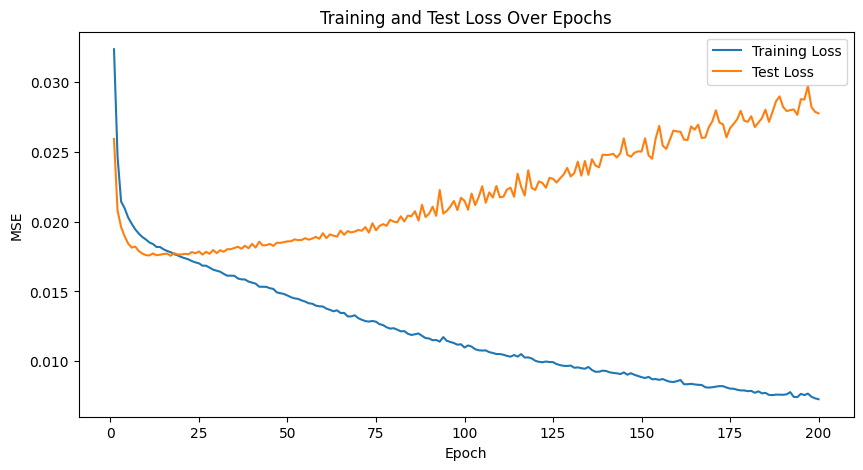

Final Test MSE: 0.027760304510593414


In [19]:
epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32, verbose=0)
    
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    
    print(f'Epoch {epoch+1}/{epochs}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
print(f'Final Test MSE: {final_mse_test}')

In [20]:
df = pd.read_csv('../../Datasets/study_213/top_5_213.csv', usecols=['DATE', '7058', '8572', '39601', '8901', '7730'])
print(df)

            DATE    7058   8572  39601   8901   7730
0     1963-11-14  1531.0  422.0   19.0  164.0    2.0
1     1963-12-10   437.0   94.0   17.0   97.0    1.0
2     1964-10-25   189.0   66.0   36.0   23.0  761.0
3     1964-10-29   370.0  116.0   83.0  196.0  561.0
4     1964-12-04   101.0    5.0   21.0  233.0    2.0
...          ...     ...    ...    ...    ...    ...
1510  2008-10-28   255.0   16.0  185.0   44.0   15.0
1511  2008-10-30   741.0  735.0  252.0   87.0  382.0
1512  2008-11-03   287.0  291.0   14.0   16.0    1.0
1513  2008-11-04   732.0  468.0   32.0  186.0    1.0
1514  2008-11-08    78.0    3.0  471.0    1.0   14.0

[1515 rows x 6 columns]


In [ ]:
for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)

"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

# 7058 ['Merluccius bilinearis']  Silver hake -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
df['7058_on_7058'] = df['7058_lag1'] * df['7058']
df['7058_on_8572'] = df['7058_lag1'] * df['8572']
df['7058_on_39601'] = df['7058_lag1'] * df['39601']
df['7058_on_8901'] = df['7058_lag1'] * df['8901']
df['7058_on_7730'] = df['7058_lag1'] * df['7730']

# 8572 ['Squalus acanthias']  Spiny dogfish -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
df['8572_on_7058'] = df['8572_lag1'] * df['7058']
df['8572_on_8572'] = df['8572_lag1'] * df['8572']
df['8572_on_39601'] = df['8572_lag1'] * df['39601']
df['8572_on_8901'] = df['8572_lag1'] * df['8901']
df['8572_on_7730'] = df['8572_lag1'] * df['7730']

# 39601 ['Doryteuthis pealeii']  Longfin inshore squid -> Silver hake, Longfin inshore squid
df['39601_on_7058'] = df['39601_lag1'] * df['7058']
df['39601_on_39601'] = df['39601_lag1'] * df['39601']

# 8901 ['Urophycis chuss']  Red hake -> Silver hake, Longfin inshore squid, Red hake, American butterfish
df['8901_on_7058'] = df['8901_lag1'] * df['7058']
df['8901_on_39601'] = df['8901_lag1'] * df['39601']
df['8901_on_8901'] = df['8901_lag1'] * df['8901']
df['8901_on_7730'] = df['8901_lag1'] * df['7730']

# 7730 ['Peprilus triacanthus']  American butterfish -> Longfin inshore squid
df['7730_on_39601'] = df['7730_lag1'] * df['39601']


df.dropna(inplace=True)
print(df)

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['7058', '8572',  '39601',  '8901',  '7730',
                                       '7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1',
                                       '7058_on_7058', '7058_on_8572', '7058_on_39601', '7058_on_8901', '7058_on_7730',
                                       '8572_on_7058', '8572_on_8572', '8572_on_39601', '8572_on_8901', '8572_on_7730',
                                       '39601_on_7058', '39601_on_39601', '8901_on_7058', '8901_on_39601', '8901_on_8901',
                                       '8901_on_7730', '7730_on_39601']])
print(scaled_data.shape)

(1514, 27)


In [23]:
xs, ys = [], []
seq_length=3
for i in range(len(scaled_data)-seq_length):
    x = scaled_data[i:(i + seq_length)]
    xs.append(x)

    y = scaled_data[i + seq_length][:5]
    ys.append(y)

X, y = np.array(xs), np.array(ys)
print(X.shape)
print(y.shape)

(1511, 3, 27)
(1511, 5)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 27)),
    Dense(5)
])

model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/200, Training MSE: 0.0073, Test MSE: 0.0068
Epoch 2/200, Training MSE: 0.0066, Test MSE: 0.0067
Epoch 3/200, Training MSE: 0.0065, Test MSE: 0.0066
Epoch 4/200, Training MSE: 0.0064, Test MSE: 0.0066
Epoch 5/200, Training MSE: 0.0064, Test MSE: 0.0066
Epoch 6/200, Training MSE: 0.0063, Test MSE: 0.0066
Epoch 7/200, Training MSE: 0.0063, Test MSE: 0.0065
Epoch 8/200, Training MSE: 0.0063, Test MSE: 0.0065
Epoch 9/200, Training MSE: 0.0062, Test MSE: 0.0065
Epoch 10/200, Training MSE: 0.0062, Test MSE: 0.0065
Epoch 11/200, Training MSE: 0.0062, Test MSE: 0.0065
Epoch 12/200, Training MSE: 0.0062, Test MSE: 0.0065
Epoch 13/200, Training MSE: 0.0061, Test MSE: 0.0065
Epoch 14/200, Training MSE: 0.0061, Test MSE: 0.0065
Epoch 15/200, Training MSE: 0.0061, Test MSE: 0.0065
Epoch 16/200, Training MSE: 0.0061, Test MSE: 0.0065
Epoch 17/200, Training MSE: 0.0060, Test MSE: 0.0065
Epoch 18/200, Training MSE: 0.0060, Test MSE: 0.0065
Epoch 19/200, Training MSE: 0.0060, Test MSE: 0.0064
Ep

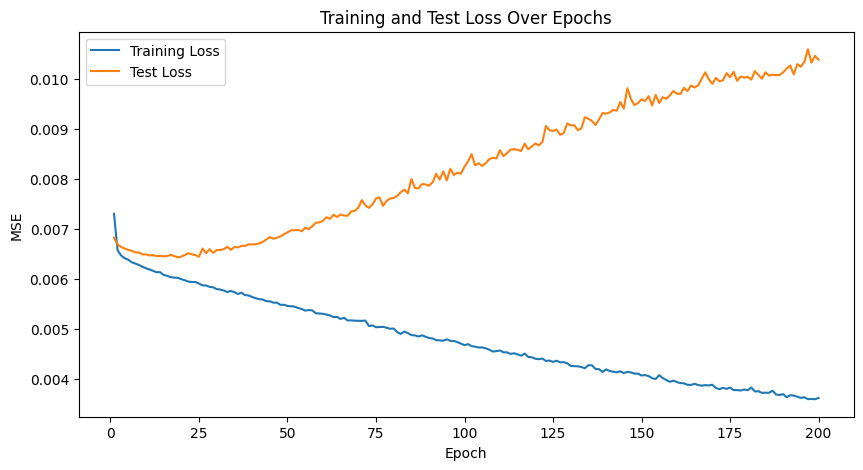

Final Test MSE: 0.01037546992301941


In [32]:
epochs = 200
train_losses = []
test_losses = []

for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32, verbose=0)
    
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    
    print(f'Epoch {epoch+1}/{epochs}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
print(f'Final Test MSE: {final_mse_test}')